In [3]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import csv

# python core library for machine learning and data science
import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib.colors import LinearSegmentedColormap

import geopandas as gpd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv("./df_todo_modelo.csv") # dataset without shift

In [3]:
df.head()

,pk_cid,pk_partition,CUST_entry_date,CUST_entry_channel,CUST_active_customer,CUST_segment,PROD_short_term_deposit,PROD_loans,PROD_mortgage,PROD_funds,PROD_securities,PROD_long_term_deposit,PROD_credit_card,PROD_payroll,PROD_pension_plan,PROD_payroll_account,PROD_emc_account,PROD_debit_card,PROD_em_acount,CUST_SOCDEM_region_code,CUST_SOCDEM_gender,CUST_SOCDEM_age,CUST_SOCDEM_salary,SALE_pk_sale,SALE_month_sale,SALE_product_ID,SALE_net_margin,SALE_product_desc,SALE_family_product,CUST_nuevo_cliente,CUST_antiguedad_meses,HAY_VENTA,provincia,CUST_grupo_edad,HAY_VENTA_fam_account,HAY_VENTA_fam_payment_card,HAY_VENTA_fam_pension_plan,HAY_VENTA_fam_investment,HAY_VENTA_fam_loan,HAY_VENTA_em_acount,HAY_VENTA_debit_card,HAY_VENTA_pension_plan,HAY_VENTA_payroll,HAY_VENTA_payroll_account,HAY_VENTA_emc_account,HAY_VENTA_credit_card,HAY_VENTA_short_term_deposit,HAY_VENTA_long_term_deposit,HAY_VENTA_securities,HAY_VENTA_funds,HAY_VENTA_loans,HAY_VENTA_mortgage,PROV_poblacion,PROV_PIB_capita,PROV_tasa_actividad,PROV_tasa_paro,PROV_tasa_empleo,PART_trimestre,PART_ano,PART_mes,PROD_total_mes_anterior,CUST_recencia_categoria
0,1375586,2018-01-01,2018-01-01,KHL,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,1,29,H,35,87218,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,Málaga,26-35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1661785,19276,55.92,22.42,43.39,1,2018,1,0,5
1,1050611,2018-01-01,2015-08-01,KHE,0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,0,0,0,1,13,V,23,35548,NaN,NaN,NaN,NaN,NaN,NaN,0,29,0,Ciudad Real,19-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,495761,21793,55.25,19.99,44.20,1,2018,1,0,5
2,1050612,2018-01-01,2015-08-01,KHE,0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,0,0,0,1,13,V,23,122179,NaN,NaN,NaN,NaN,NaN,NaN,0,29,0,Ciudad Real,19-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,495761,21793,55.25,19.99,44.20,1,2018,1,0,5
3,1050613,2018-01-01,2015-08-01,KHD,0,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0,0,0,0,0,0,50,H,22,119775,NaN,NaN,NaN,NaN,NaN,NaN,0,29,0,Zaragoza,19-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,964693,28980,58.71,12.97,51.09,1,2018,1,0,5
4,1050614,2018-01-01,2015-08-01,KHE,1,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,0,0,0,1,50,V,23,102881,NaN,NaN,NaN,NaN,NaN,NaN,0,29,0,Zaragoza,19-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,964693,28980,58.71,12.97,51.09,1,2018,1,0,5


In [4]:
cols_to_drop = [col for col in df.columns if col.startswith('HAY_VENTA')]
df.drop(columns=cols_to_drop, inplace=True)

In [5]:
df['pk_cid'].count()

5998682

In [6]:
df['pk_cid'].nunique()

456223

1. Creation of the Cluster Dataset

In [ ]:
# We keep the last partition of each client to create the cluster since it is the most recent snapshot
# Convert the 'pk_partition' column to datetime format
df['pk_partition'] = pd.to_datetime(df['pk_partition'])

# Sort the DataFrame by 'pk_cid' and 'pk_partition' in descending order.
df = df.sort_values(by=['pk_cid', 'pk_partition'], ascending=[True, False])

# Remove duplicates, keeping only the row with the most recent date.
df = df.drop_duplicates(subset='pk_cid', keep='first')

# reset the index
df.reset_index(drop=True, inplace=True)

In [ ]:
# OHE for CUST_segment
df['CUST_segment'].value_counts()

CUST_segment
03 - UNIVERSITARIO    288589
02 - PARTICULARES     150671
desconocido             8750
01 - TOP                8213
Name: count, dtype: int64

In [ ]:
# Replace DESCONOCIDO for 03 - UNIVERSITARIO
df['CUST_segment'] = df['CUST_segment'].replace('desconocido', '03 - UNIVERSITARIO')

In [ ]:
# OHE for  CUST_segment
df_dummies = pd.get_dummies(df['CUST_segment'], prefix='CUST_segment')
df_dummies.columns = ['CUST_segment_UNIVERSITARIO', 'CUST_segment_PARTICULARES', 'CUST_segment_TOP']
df_dummies = df_dummies.astype(int)
df = pd.concat([df.drop(columns=['CUST_segment']), df_dummies], axis=1)

In [ ]:
#OHE for CUST_SOCDEM_gender
df_dummies = pd.get_dummies(df['CUST_SOCDEM_gender'], prefix='CUST_SOCDEM_gender')
df_dummies.columns = ['CUST_SOCDEM_gender_H', 'CUST_SOCDEM_gender_V']
df_dummies = df_dummies.astype(int)
df = pd.concat([df.drop(columns=['CUST_SOCDEM_gender']), df_dummies], axis=1)

In [12]:
df.head()

,pk_cid,pk_partition,CUST_entry_date,CUST_entry_channel,CUST_active_customer,PROD_short_term_deposit,PROD_loans,PROD_mortgage,PROD_funds,PROD_securities,PROD_long_term_deposit,PROD_credit_card,PROD_payroll,PROD_pension_plan,PROD_payroll_account,PROD_emc_account,PROD_debit_card,PROD_em_acount,CUST_SOCDEM_region_code,CUST_SOCDEM_age,CUST_SOCDEM_salary,SALE_pk_sale,SALE_month_sale,SALE_product_ID,SALE_net_margin,SALE_product_desc,SALE_family_product,CUST_nuevo_cliente,CUST_antiguedad_meses,provincia,CUST_grupo_edad,PROV_poblacion,PROV_PIB_capita,PROV_tasa_actividad,PROV_tasa_paro,PROV_tasa_empleo,PART_trimestre,PART_ano,PART_mes,PROD_total_mes_anterior,CUST_recencia_categoria,CUST_segment_UNIVERSITARIO,CUST_segment_PARTICULARES,CUST_segment_TOP,CUST_SOCDEM_gender_H,CUST_SOCDEM_gender_V
0,15891,2018-08-01,2018-07-01,KAT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,59,136607,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Madrid,56-65,6663394,36206,63.31,12.15,55.62,3,2018,8,1,0,0,1,0,1,0
1,16063,2019-05-01,2018-11-01,KAT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,62,136607,NaN,NaN,NaN,NaN,NaN,NaN,0,6,Madrid,56-65,6663394,36206,63.31,12.15,55.62,2,2019,5,0,6,0,1,0,1,0
2,16203,2019-05-01,2018-12-01,KAT,1,0,0,0,0,0,0,0,0,0,0,0,0,1,8,70,126607,NaN,NaN,NaN,NaN,NaN,NaN,0,5,Barcelona,65+,5664579,31950,61.08,12.36,53.53,2,2019,5,1,2,1,0,0,0,1
3,16502,2019-05-01,2018-09-01,KHN,1,0,0,0,0,0,0,0,0,0,0,1,0,1,28,58,136607,NaN,NaN,NaN,NaN,NaN,NaN,0,8,Madrid,56-65,6663394,36206,63.31,12.15,55.62,2,2019,5,2,2,0,1,0,1,0
4,17457,2019-05-01,2017-09-01,KAT,1,0,0,0,0,0,1,0,0,0,0,0,1,1,28,54,102405,NaN,NaN,NaN,NaN,NaN,NaN,0,20,Madrid,46-55,6663394,36206,63.31,12.15,55.62,2,2019,5,2,3,0,1,0,1,0


In [ ]:
# Convert CUST_entry_date to datetime
df['CUST_entry_date'] = pd.to_datetime(df['CUST_entry_date'], format = "%Y-%m-%d")

In [ ]:
# create a new feature that differentiates between young (<30) and adult (>=31)
# Create columns for each age range.
df['edad_menor_30'] = df['CUST_SOCDEM_age'].apply(lambda x: x < 30)
df['edad_30_50'] = df['CUST_SOCDEM_age'].apply(lambda x: 30 <= x <= 50)
df['edad_mayor_50'] = df['CUST_SOCDEM_age'].apply(lambda x: x > 50)

# Convert the booleans to 1 or 0.
df['edad_menor_30'] = df['edad_menor_30'].astype(int)
df['edad_30_50']= df['edad_30_50'].astype(int)
df['edad_mayor_50']= df['edad_mayor_50'].astype(int)

In [15]:
df['edad_menor_30'].value_counts(normalize=True)

edad_menor_30
1    0.638227
0    0.361773
Name: proportion, dtype: float64

In [ ]:
#Create a feature for total products of the current month.
product_columns = [
    'PROD_short_term_deposit',
    'PROD_loans',
    'PROD_mortgage',
    'PROD_funds',
    'PROD_securities',
    'PROD_long_term_deposit',
    'PROD_credit_card',
    'PROD_payroll',
    'PROD_pension_plan',
    'PROD_payroll_account',
    'PROD_emc_account',
    'PROD_debit_card',
    'PROD_em_acount'
]

df['Total_Productos'] = df[product_columns].sum(axis=1)

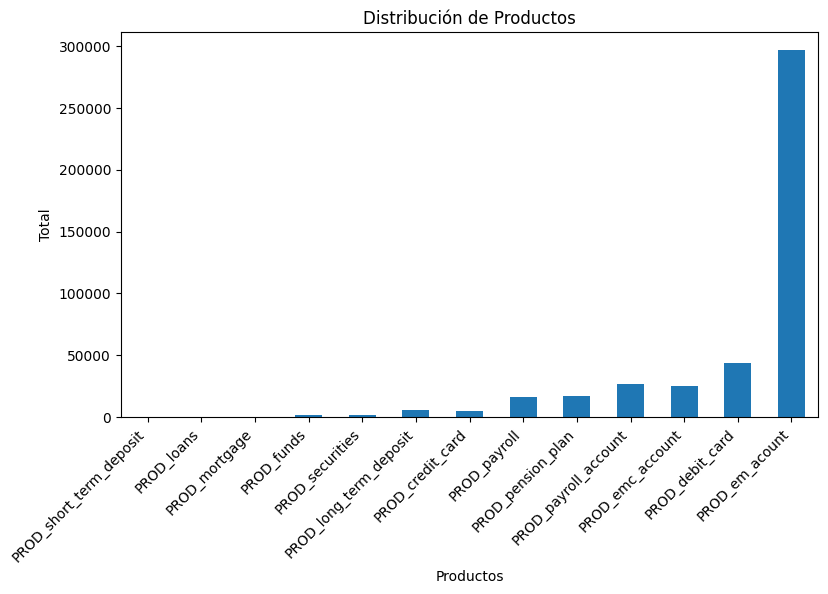

In [ ]:
# Create groups of products

product_totals = df[product_columns].sum()

plt.figure(figsize=(9, 5))
product_totals.plot(kind='bar')
plt.title('Distribución de Productos')
plt.xlabel('Productos')
plt.ylabel('Total')
plt.xticks(rotation=45, ha='right')
plt.show()

In [18]:
# PROD_TARJETAS
df['PROD_TARJETAS'] = df[['PROD_debit_card', 'PROD_credit_card']].apply(lambda x: 1 if x.sum() > 0 else 0, axis=1)

# PROD_CUENTA_BANCARIA
df['PROD_CUENTA_BANCARIA'] = df[['PROD_emc_account', 'PROD_em_acount', 'PROD_payroll_account', 'PROD_payroll']].apply(lambda x: 1 if x.sum() > 0 else 0, axis=1)

# PROD_INVERSIONES
df['PROD_INVERSIONES'] = df[['PROD_short_term_deposit', 'PROD_funds', 'PROD_securities', 
                             'PROD_long_term_deposit']].apply(lambda x: 1 if x.sum() > 0 else 0, axis=1)

# PROD_PRESTAMOS
df['PROD_PRESTAMOS'] = df[['PROD_loans', 'PROD_mortgage']].apply(lambda x: 1 if x.sum() > 0 else 0, axis=1)

# PROD_PENSION
df['PROD_PENSION'] = df[['PROD_pension_plan']].apply(lambda x: 1 if x.sum() > 0 else 0, axis=1)


In [19]:
df['CUST_active_customer'].value_counts()

CUST_active_customer
0    284017
1    172206
Name: count, dtype: int64

In [20]:
df['provincia'].value_counts(normalize=True)*100

provincia
Madrid                    21.535083
Barcelona                 10.118078
Valencia/València          6.074003
Murcia                     4.766748
Sevilla                    4.671400
Coruña, A                  3.974591
Málaga                     2.979026
Alicante                   2.952723
Pontevedra                 2.774740
Cádiz                      2.573522
Asturias                   2.219748
Zaragoza                   2.182266
Palmas, Las                2.077712
Badajoz                    1.913319
Valladolid                 1.843397
Toledo                     1.710786
Granada                    1.689744
Salamanca                  1.467922
Cáceres                    1.273062
Córdoba                    1.245005
Cantabria                  1.198537
Balears, Illes             1.156890
Albacete                   1.147904
Ciudad Real                1.115463
Huelva                     1.106696
Castellón/Castelló         1.092448
Tarragona                  1.020115
Ourense           

In [21]:
zona_geo = {
    'Zona_Norte': ['Coruña, A','Pontevedra','Asturias','Cantabria','Ourense','Lugo','Bizkaia','Rioja, La', 'Navarra','Gipuzkoa','Araba/Álava','Huesca','Teruel','Zaragoza'
        
    ],
    'Zona_Centro': ['Madrid', 'Badajoz','Valladolid','Toledo','Salamanca','Cáceres','Albacete','Ciudad Real','Burgos','León','Cuenca','Guadalajara','Zamora','Palencia','Segovia','Ávila','Soria',
    ],
    'Zona_Este': ['Barcelona', 'Valencia/València', 'Alicante','Balears, Illes','Castellón/Castelló','Tarragona','Girona','Lleida'
        
    ],
    'Zona_Sur': ['Murcia','Sevilla','Málaga','Cádiz','Palmas, Las','Granada','Córdoba','Huelva','Almería','Santa Cruz de Tenerife','Jaén','Ceuta', 'Melilla'
        
    ]
}

In [22]:
df.head()

,pk_cid,pk_partition,CUST_entry_date,CUST_entry_channel,CUST_active_customer,PROD_short_term_deposit,PROD_loans,PROD_mortgage,PROD_funds,PROD_securities,PROD_long_term_deposit,PROD_credit_card,PROD_payroll,PROD_pension_plan,PROD_payroll_account,PROD_emc_account,PROD_debit_card,PROD_em_acount,CUST_SOCDEM_region_code,CUST_SOCDEM_age,CUST_SOCDEM_salary,SALE_pk_sale,SALE_month_sale,SALE_product_ID,SALE_net_margin,SALE_product_desc,SALE_family_product,CUST_nuevo_cliente,CUST_antiguedad_meses,provincia,CUST_grupo_edad,PROV_poblacion,PROV_PIB_capita,PROV_tasa_actividad,PROV_tasa_paro,PROV_tasa_empleo,PART_trimestre,PART_ano,PART_mes,PROD_total_mes_anterior,CUST_recencia_categoria,CUST_segment_UNIVERSITARIO,CUST_segment_PARTICULARES,CUST_segment_TOP,CUST_SOCDEM_gender_H,CUST_SOCDEM_gender_V,edad_menor_30,edad_30_50,edad_mayor_50,Total_Productos,PROD_TARJETAS,PROD_CUENTA_BANCARIA,PROD_INVERSIONES,PROD_PRESTAMOS,PROD_PENSION
0,15891,2018-08-01,2018-07-01,KAT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,59,136607,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Madrid,56-65,6663394,36206,63.31,12.15,55.62,3,2018,8,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
1,16063,2019-05-01,2018-11-01,KAT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,62,136607,NaN,NaN,NaN,NaN,NaN,NaN,0,6,Madrid,56-65,6663394,36206,63.31,12.15,55.62,2,2019,5,0,6,0,1,0,1,0,0,0,1,0,0,0,0,0,0
2,16203,2019-05-01,2018-12-01,KAT,1,0,0,0,0,0,0,0,0,0,0,0,0,1,8,70,126607,NaN,NaN,NaN,NaN,NaN,NaN,0,5,Barcelona,65+,5664579,31950,61.08,12.36,53.53,2,2019,5,1,2,1,0,0,0,1,0,0,1,1,0,1,0,0,0
3,16502,2019-05-01,2018-09-01,KHN,1,0,0,0,0,0,0,0,0,0,0,1,0,1,28,58,136607,NaN,NaN,NaN,NaN,NaN,NaN,0,8,Madrid,56-65,6663394,36206,63.31,12.15,55.62,2,2019,5,2,2,0,1,0,1,0,0,0,1,2,0,1,0,0,0
4,17457,2019-05-01,2017-09-01,KAT,1,0,0,0,0,0,1,0,0,0,0,0,1,1,28,54,102405,NaN,NaN,NaN,NaN,NaN,NaN,0,20,Madrid,46-55,6663394,36206,63.31,12.15,55.62,2,2019,5,2,3,0,1,0,1,0,0,0,1,3,1,1,1,0,0


In [23]:
def asignar_zona(provincia):
    for zona, provincias in zona_geo.items():
        if provincia in provincias:
            return zona
    return 'Zona_Desconocida'

df['zona_geo'] = df['provincia'].apply(asignar_zona)


In [24]:
df['zona_geo'].value_counts(normalize=True)

zona_geo
Zona_Centro    0.362222
Zona_Este      0.240027
Zona_Sur       0.228956
Zona_Norte     0.168795
Name: proportion, dtype: float64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456223 entries, 0 to 456222
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   pk_cid                      456223 non-null  int64         
 1   pk_partition                456223 non-null  datetime64[ns]
 2   CUST_entry_date             456223 non-null  datetime64[ns]
 3   CUST_entry_channel          456223 non-null  object        
 4   CUST_active_customer        456223 non-null  int64         
 5   PROD_short_term_deposit     456223 non-null  int64         
 6   PROD_loans                  456223 non-null  int64         
 7   PROD_mortgage               456223 non-null  int64         
 8   PROD_funds                  456223 non-null  int64         
 9   PROD_securities             456223 non-null  int64         
 10  PROD_long_term_deposit      456223 non-null  int64         
 11  PROD_credit_card            456223 non-

In [ ]:
# Customers that appear in the dataset with contracted products.
df = df[df['Total_Productos'] > 0]

In [27]:
df['pk_cid'].count()

331917

2. Feature selection

In [28]:
dummies = pd.get_dummies(df['zona_geo'], prefix='', prefix_sep='')
dummies = dummies.astype(int)
df = pd.concat([df, dummies], axis=1)

In [29]:
df.head()

,pk_cid,pk_partition,CUST_entry_date,CUST_entry_channel,CUST_active_customer,PROD_short_term_deposit,PROD_loans,PROD_mortgage,PROD_funds,PROD_securities,PROD_long_term_deposit,PROD_credit_card,PROD_payroll,PROD_pension_plan,PROD_payroll_account,PROD_emc_account,PROD_debit_card,PROD_em_acount,CUST_SOCDEM_region_code,CUST_SOCDEM_age,CUST_SOCDEM_salary,SALE_pk_sale,SALE_month_sale,SALE_product_ID,SALE_net_margin,SALE_product_desc,SALE_family_product,CUST_nuevo_cliente,CUST_antiguedad_meses,provincia,CUST_grupo_edad,PROV_poblacion,PROV_PIB_capita,PROV_tasa_actividad,PROV_tasa_paro,PROV_tasa_empleo,PART_trimestre,PART_ano,PART_mes,PROD_total_mes_anterior,CUST_recencia_categoria,CUST_segment_UNIVERSITARIO,CUST_segment_PARTICULARES,CUST_segment_TOP,CUST_SOCDEM_gender_H,CUST_SOCDEM_gender_V,edad_menor_30,edad_30_50,edad_mayor_50,Total_Productos,PROD_TARJETAS,PROD_CUENTA_BANCARIA,PROD_INVERSIONES,PROD_PRESTAMOS,PROD_PENSION,zona_geo,Zona_Centro,Zona_Este,Zona_Norte,Zona_Sur
2,16203,2019-05-01,2018-12-01,KAT,1,0,0,0,0,0,0,0,0,0,0,0,0,1,8,70,126607,NaN,NaN,NaN,NaN,NaN,NaN,0,5,Barcelona,65+,5664579,31950,61.08,12.36,53.53,2,2019,5,1,2,1,0,0,0,1,0,0,1,1,0,1,0,0,0,Zona_Este,0,1,0,0
3,16502,2019-05-01,2018-09-01,KHN,1,0,0,0,0,0,0,0,0,0,0,1,0,1,28,58,136607,NaN,NaN,NaN,NaN,NaN,NaN,0,8,Madrid,56-65,6663394,36206,63.31,12.15,55.62,2,2019,5,2,2,0,1,0,1,0,0,0,1,2,0,1,0,0,0,Zona_Centro,1,0,0,0
4,17457,2019-05-01,2017-09-01,KAT,1,0,0,0,0,0,1,0,0,0,0,0,1,1,28,54,102405,NaN,NaN,NaN,NaN,NaN,NaN,0,20,Madrid,46-55,6663394,36206,63.31,12.15,55.62,2,2019,5,2,3,0,1,0,1,0,0,0,1,3,1,1,1,0,0,Zona_Centro,1,0,0,0
6,17799,2019-05-01,2018-01-01,KAT,1,0,0,0,0,0,0,0,0,0,0,0,0,1,28,47,84511,NaN,NaN,NaN,NaN,NaN,NaN,0,16,Madrid,46-55,6663394,36206,63.31,12.15,55.62,2,2019,5,1,5,0,1,0,1,0,0,1,0,1,0,1,0,0,0,Zona_Centro,1,0,0,0
7,17970,2019-05-01,2015-04-01,KAT,1,0,0,0,0,1,0,0,0,1,1,1,1,0,28,76,128634,NaN,NaN,NaN,NaN,NaN,NaN,0,50,Madrid,65+,6663394,36206,63.31,12.15,55.62,2,2019,5,5,1,0,1,0,0,1,0,0,1,5,1,1,1,0,1,Zona_Centro,1,0,0,0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 331917 entries, 2 to 456132
Data columns (total 60 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   pk_cid                      331917 non-null  int64         
 1   pk_partition                331917 non-null  datetime64[ns]
 2   CUST_entry_date             331917 non-null  datetime64[ns]
 3   CUST_entry_channel          331917 non-null  object        
 4   CUST_active_customer        331917 non-null  int64         
 5   PROD_short_term_deposit     331917 non-null  int64         
 6   PROD_loans                  331917 non-null  int64         
 7   PROD_mortgage               331917 non-null  int64         
 8   PROD_funds                  331917 non-null  int64         
 9   PROD_securities             331917 non-null  int64         
 10  PROD_long_term_deposit      331917 non-null  int64         
 11  PROD_credit_card            331917 non-null 

In [ ]:
# Selection of features for clustering.
features = [
'PROD_TARJETAS', 'PROD_INVERSIONES', 'PROD_PENSION', 'PROD_PRESTAMOS',
'Zona_Norte', 'Zona_Centro', 'Zona_Este', 'Zona_Sur', 
'CUST_active_customer', 'CUST_SOCDEM_age'
]

In [50]:
X = df[features]

3. Normalization

In [ ]:

X_normalized = X.copy()

# Select features to normalize
columns_to_normalize = ['CUST_SOCDEM_age']

# StandardScaler
scaler = StandardScaler()

# Apply StandardScaler to selected features 
X_normalized[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])

In [52]:
X_normalized.head()

,PROD_TARJETAS,PROD_INVERSIONES,PROD_PENSION,PROD_PRESTAMOS,Zona_Norte,Zona_Centro,Zona_Este,Zona_Sur,CUST_active_customer,CUST_SOCDEM_age
2,0,0,0,0,0,0,1,0,1,3.353568
3,0,0,0,0,0,1,0,0,1,2.340659
4,1,1,0,0,0,1,0,0,1,2.003022
6,0,0,0,0,0,1,0,0,1,1.412158
7,1,1,1,0,0,1,0,0,1,3.860023


4. Apply K-means

In [53]:
sse = {}

for k in range(2, 14):

    print(f"Fitting pipe with {k} clusters")

    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(X)

    sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters


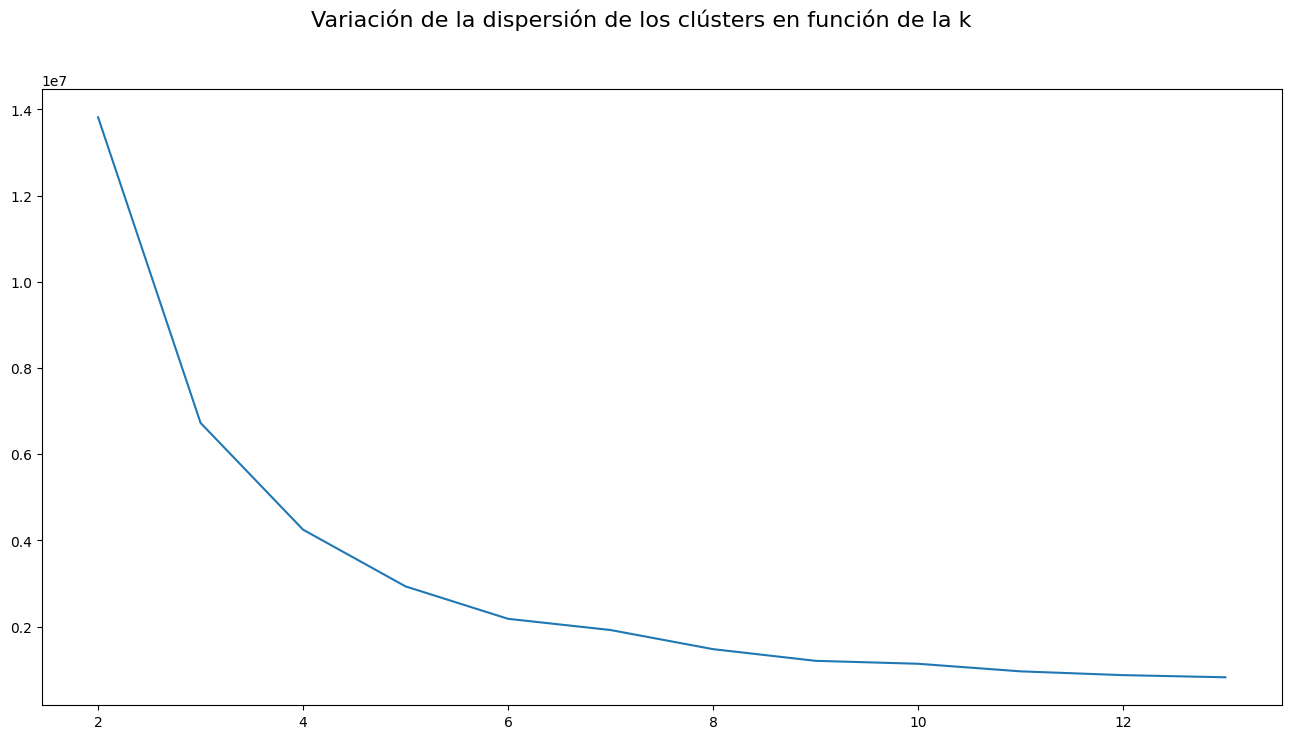

In [54]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

In [ ]:
# Apply K-means with the clusters
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_normalized)

In [56]:
df_final=df.copy()

In [ ]:
# Agregate clusters to original dataset
df_final['Cluster'] = clusters

In [58]:
df_final.groupby("Cluster").size()

Cluster
0    74489
1    58677
2    22668
3    60255
4    51296
5    64532
dtype: int64

In [59]:
df_final.head()

,pk_cid,pk_partition,CUST_entry_date,CUST_entry_channel,CUST_active_customer,PROD_short_term_deposit,PROD_loans,PROD_mortgage,PROD_funds,PROD_securities,PROD_long_term_deposit,PROD_credit_card,PROD_payroll,PROD_pension_plan,PROD_payroll_account,PROD_emc_account,PROD_debit_card,PROD_em_acount,CUST_SOCDEM_region_code,CUST_SOCDEM_age,CUST_SOCDEM_salary,SALE_pk_sale,SALE_month_sale,SALE_product_ID,SALE_net_margin,SALE_product_desc,SALE_family_product,CUST_nuevo_cliente,CUST_antiguedad_meses,provincia,CUST_grupo_edad,PROV_poblacion,PROV_PIB_capita,PROV_tasa_actividad,PROV_tasa_paro,PROV_tasa_empleo,PART_trimestre,PART_ano,PART_mes,PROD_total_mes_anterior,CUST_recencia_categoria,CUST_segment_UNIVERSITARIO,CUST_segment_PARTICULARES,CUST_segment_TOP,CUST_SOCDEM_gender_H,CUST_SOCDEM_gender_V,edad_menor_30,edad_30_50,edad_mayor_50,Total_Productos,PROD_TARJETAS,PROD_CUENTA_BANCARIA,PROD_INVERSIONES,PROD_PRESTAMOS,PROD_PENSION,zona_geo,Zona_Centro,Zona_Este,Zona_Norte,Zona_Sur,Cluster
2,16203,2019-05-01,2018-12-01,KAT,1,0,0,0,0,0,0,0,0,0,0,0,0,1,8,70,126607,NaN,NaN,NaN,NaN,NaN,NaN,0,5,Barcelona,65+,5664579,31950,61.08,12.36,53.53,2,2019,5,1,2,1,0,0,0,1,0,0,1,1,0,1,0,0,0,Zona_Este,0,1,0,0,2
3,16502,2019-05-01,2018-09-01,KHN,1,0,0,0,0,0,0,0,0,0,0,1,0,1,28,58,136607,NaN,NaN,NaN,NaN,NaN,NaN,0,8,Madrid,56-65,6663394,36206,63.31,12.15,55.62,2,2019,5,2,2,0,1,0,1,0,0,0,1,2,0,1,0,0,0,Zona_Centro,1,0,0,0,2
4,17457,2019-05-01,2017-09-01,KAT,1,0,0,0,0,0,1,0,0,0,0,0,1,1,28,54,102405,NaN,NaN,NaN,NaN,NaN,NaN,0,20,Madrid,46-55,6663394,36206,63.31,12.15,55.62,2,2019,5,2,3,0,1,0,1,0,0,0,1,3,1,1,1,0,0,Zona_Centro,1,0,0,0,2
6,17799,2019-05-01,2018-01-01,KAT,1,0,0,0,0,0,0,0,0,0,0,0,0,1,28,47,84511,NaN,NaN,NaN,NaN,NaN,NaN,0,16,Madrid,46-55,6663394,36206,63.31,12.15,55.62,2,2019,5,1,5,0,1,0,1,0,0,1,0,1,0,1,0,0,0,Zona_Centro,1,0,0,0,1
7,17970,2019-05-01,2015-04-01,KAT,1,0,0,0,0,1,0,0,0,1,1,1,1,0,28,76,128634,NaN,NaN,NaN,NaN,NaN,NaN,0,50,Madrid,65+,6663394,36206,63.31,12.15,55.62,2,2019,5,5,1,0,1,0,0,1,0,0,1,5,1,1,1,0,1,Zona_Centro,1,0,0,0,2


5. Revertir normalización

In [ ]:
# Revert normalization
X_reverted = X_normalized.copy()
# Revert normalization applying the same StandardScaler
X_reverted[columns_to_normalize] = scaler.inverse_transform(X_normalized[columns_to_normalize])

In [ ]:
# Add clusters to the DataFrame used for clustering.
X_reverted['Cluster'] = clusters

In [62]:
X_reverted.head()

,PROD_TARJETAS,PROD_INVERSIONES,PROD_PENSION,PROD_PRESTAMOS,Zona_Norte,Zona_Centro,Zona_Este,Zona_Sur,CUST_active_customer,CUST_SOCDEM_age,Cluster
2,0,0,0,0,0,0,1,0,1,70.0,2
3,0,0,0,0,0,1,0,0,1,58.0,2
4,1,1,0,0,0,1,0,0,1,54.0,2
6,0,0,0,0,0,1,0,0,1,47.0,1
7,1,1,1,0,0,1,0,0,1,76.0,2


6. Cluster Analysis

In [63]:
X_reverted['Cluster'].value_counts(normalize=True).sort_index()*100

Cluster
0    22.442056
1    17.678215
2     6.829418
3    18.153635
4    15.454466
5    19.442210
Name: proportion, dtype: float64

In [52]:
df_clus_0 = X_reverted[X_reverted['Cluster'] == 0]
df_clus_1 = X_reverted[X_reverted['Cluster'] == 1]
df_clus_2 = X_reverted[X_reverted['Cluster'] == 2]
df_clus_3 = X_reverted[X_reverted['Cluster'] == 3]
df_clus_4 = X_reverted[X_reverted['Cluster'] == 4]
df_clus_5 = X_reverted[X_reverted['Cluster'] == 5]

In [ ]:
# Create a dictonary to save the dataframes of each cluster
clusters = {}
for i in range(5):
    clusters[f'df_clus_{i}'] = X_reverted[X_reverted['Cluster'] == i]

# Descriptive_stats
descriptive_stats = {}
for key, df in clusters.items():
    descriptive_stats[key] = df.describe(include='all')

descriptive_stats

{'df_clus_0':        PROD_TARJETAS  PROD_INVERSIONES  PROD_PENSION  PROD_PRESTAMOS  \
 count   74489.000000      74489.000000  74489.000000    74489.000000   
 mean        0.082455          0.006954      0.039254        0.000107   
 std         0.275059          0.083101      0.194200        0.010363   
 min         0.000000          0.000000      0.000000        0.000000   
 25%         0.000000          0.000000      0.000000        0.000000   
 50%         0.000000          0.000000      0.000000        0.000000   
 75%         0.000000          0.000000      0.000000        0.000000   
 max         1.000000          1.000000      1.000000        1.000000   
 
        Zona_Norte  Zona_Centro  Zona_Este  Zona_Sur  CUST_active_customer  \
 count     74489.0      74489.0    74489.0   74489.0          74489.000000   
 mean          0.0          1.0        0.0       0.0              0.471452   
 std           0.0          0.0        0.0       0.0              0.499188   
 min           0

In [66]:
ficha_df = pd.DataFrame()

In [67]:
for i, col in enumerate(['PROD_TARJETAS', 'PROD_INVERSIONES', 'PROD_PENSION', 'PROD_PRESTAMOS',
'Zona_Norte', 'Zona_Centro', 'Zona_Este', 'Zona_Sur', 
'CUST_active_customer', 'CUST_SOCDEM_age']):
    resumen_data = X_reverted[["Cluster", col]].groupby("Cluster").describe().T[1:]
    ficha_df = pd.concat([ficha_df, resumen_data])

In [68]:
ficha_df.round()

Cluster                  0     1      2     3     4     5
PROD_TARJETAS   mean   0.0   0.0    0.0   0.0   0.0   0.0
                std    0.0   0.0    0.0   0.0   0.0   0.0
                min    0.0   0.0    0.0   0.0   0.0   0.0
                25%    0.0   0.0    0.0   0.0   0.0   0.0
                50%    0.0   0.0    0.0   0.0   0.0   0.0
...                    ...   ...    ...   ...   ...   ...
CUST_SOCDEM_age min    3.0  31.0   51.0  17.0   5.0   7.0
                25%   22.0  37.0   55.0  22.0  22.0  22.0
                50%   24.0  41.0   60.0  23.0  23.0  24.0
                75%   27.0  46.0   67.0  26.0  26.0  27.0
                max   38.0  53.0  105.0  40.0  40.0  41.0

[70 rows x 6 columns]

In [69]:
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
colors = ['white', 'darkblue']
n_bins = 100  # Número de bins para el gradiente
cmap_name = 'white_to_darkblue'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Apply color gradient to each row
styled_df = ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

In [71]:
styled_df

In [72]:
df_final['PROV_tasa_empleo'] = df_final['PROV_tasa_empleo'].astype(int)
df_final['PROV_tasa_paro'] = df_final['PROV_tasa_paro'].astype(int)
df_final['PROV_tasa_actividad'] = df_final['PROV_tasa_actividad'].astype(int)

In [73]:
output_directory = 'C:/Users/aleja/Documents/Data Science/Apuntes/TFM/easyMoney'  

output_path = os.path.join(output_directory, 'df_final_solo_clientes_1.csv')
df_final.to_csv(output_path, index=False)